In [1]:
!unzip 'hw4.zip'

Archive:  hw4.zip
  inflating: HW4.tex                 
  inflating: backprop_example1.txt   
  inflating: backprop_example2.txt   
   creating: datasets/
  inflating: datasets/hw3_cancer.csv  
  inflating: datasets/hw3_house_votes_84.csv  
  inflating: datasets/hw3_wine.csv   
   creating: figures/
  inflating: figures/.DS_Store       
  inflating: figures/network_example.pdf  


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [3]:
class NN:
    def __init__(self, sizes, initial_weights=None, eta=0.01, reg_lambda=0.01, use_softmax=False):
        self.sizes = sizes
        self.eta = eta
        self.reg_lambda = reg_lambda
        self.use_softmax = use_softmax
        self.weights = self.init_weights() if initial_weights is None else initial_weights

    def init_weights(self):
        return [np.random.randn(y, x + 1) * 0.1 for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def add_bias(self, X):
        return np.insert(X, 0, 1, axis=1)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        act = [self.add_bias(X)]
        ll = []
        for index, weight in enumerate(self.weights[:-1]):
            ll.append(act[-1] @ weight.T)
            act.append(self.add_bias(1 / (1 + np.exp(-ll[-1]))))
        ll.append(act[-1] @ self.weights[-1].T)
        act.append(self.softmax(ll[-1]) if self.use_softmax else 1 / (1 + np.exp(-ll[-1])))
        return act, ll

    def cost(self, Y, act):
        xq = Y.shape[0]
        return -np.sum(Y * np.log(act[-1] + 1e-8)) / xq if self.use_softmax else -np.sum(Y * np.log(act[-1]) + (1 - Y) * np.log(1 - act[-1])) / xq

    def backward(self, targets, activations, weights):
        num_samples = targets.shape[0]
        errors = [activations[-1] - targets]
        gradients = []
        for i in range(len(weights) - 1, 0, -1):
            delta = (errors[0] @ weights[i][:, 1:]) * activations[i][:, 1:] * (1 - activations[i][:, 1:])
            errors.insert(0, delta)
        for i in range(len(weights)):
            grad = errors[i].T @ activations[i] / num_samples
            gradients.append(grad)
        return errors, gradients

    def update_weights(self, gradients):
        for i in range(len(self.weights)):
            regularization_grad = (self.reg_lambda * self.weights[i]) / self.weights[i].shape[0]
            regularization_grad[:, 0] = 0
            self.weights[i] -= self.eta * (gradients[i] + regularization_grad)

    def predict(self, inputs):
        final_activations, _ = self.forward(inputs)
        return np.argmax(final_activations[-1], axis=1) + 1

    def train(self, inputs, labels, iterations):
        for _ in range(iterations):
            final_activations, _ = self.forward(inputs)
            _, weight_gradients = self.backward(labels, final_activations, self.weights)
            self.update_weights(weight_gradients)
        return self.weights


#Wine Dataset

The goal, here, is to predict the type of a wine based on its chemical contents.
The dataset is composed of 178 instances. Each instance is described by 13 numerical attributes, and
there are 3 classes.


In [4]:
wine_dataset = pd.read_csv('datasets/hw3_wine.csv')
wine_dataset = pd.read_csv('datasets/hw3_wine.csv', delimiter='\t')
wine_dataset = wine_dataset.sample(frac=1)
wine_dataset.columns = ['class'] + ['attribute' + str(i) for i in range(1, 14)]
wine_features = wine_dataset.drop('class', axis=1).values
wine_labels = wine_dataset['class'].values

In [5]:
def accuracy(Y, predictions):
    true_labels = np.argmax(Y, axis=1) + 1
    accuracy = np.mean(predictions == true_labels)
    return accuracy * 100

def f1_score(Y, predictions):
    true_labels = np.argmax(Y, axis=1) + 1
    classes = np.unique(true_labels)
    f1_scores = []
    for c in classes:
        tp = np.sum((predictions == c) & (true_labels == c))
        fp = np.sum((predictions == c) & (true_labels != c))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        fn = np.sum((predictions != c) & (true_labels == c))
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    avg_f1 = np.mean(f1_scores) * 100
    return avg_f1

In [6]:
def stratified_cross_validation(features, labels, k=10):
    label_indices = [np.where(labels == label)[0] for label in np.unique(labels)]
    folds = []
    pairs = []
    shuffled_label_indices = [np.random.permutation(label_list) for label_list in label_indices]
    label_splits = [np.array_split(label_list, k) for label_list in shuffled_label_indices]
    for fold_parts in zip(*label_splits):
        fold = np.concatenate(fold_parts)
        folds.append(fold)
    for fold_index in range(k):
        test_fold = folds[fold_index]
        train_fold = np.concatenate([folds[i] for i in range(k) if i != fold_index])
        pairs.append((train_fold, test_fold))
    return pairs


In [7]:
wine_features_scaled = StandardScaler().fit_transform(wine_features)
encoder = OneHotEncoder(sparse=False)
wine_labels_encoded = encoder.fit_transform(wine_labels.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(wine_features_scaled, wine_labels_encoded, test_size=0.2, random_state=42)

nn = NN([13, 8, 5, 3], eta=0.1, reg_lambda=0.05, use_softmax=True)
trained_weights = nn.train(X_train, y_train, iterations=20000)
train_predictions = nn.predict(X_train)
train_accuracy = accuracy(y_train, train_predictions)
print(f"Training Accuracy: {train_accuracy:.2f}%")
test_predictions = nn.predict(X_test)
test_accuracy = accuracy(y_test, test_predictions)
print(f"Testing Accuracy: {test_accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Training Accuracy: 100.00%
Testing Accuracy: 97.22%


In [8]:
structures = [
    ([13, 8, 3], 0.01, 0.05),
    ([13, 8, 3], 0.01, 0.1),
    ([13, 16, 3], 0.05, 0.05),
    ([13, 16, 3], 0.05, 0.1),
    ([13, 4, 4, 4, 3], 0.1, 0.05),
    ([13, 4, 4, 4, 3], 0.1, 0.1),
    ([13, 8, 8, 8, 3], 0.05, 0.05),
    ([13, 8, 8, 8, 3], 0.05, 0.1),
    ([13, 16, 16, 16, 3], 0.01, 0.05),
    ([13, 16, 16, 16, 3], 0.01, 0.1),
    ([13, 32, 32, 32, 32, 3], 0.05, 0.05),
    ([13, 32, 32, 32, 32, 3], 0.05, 0.5)
]
results = []
label_classes = np.argmax(wine_labels_encoded, axis=1)
for config, lambda_reg, learning_rate in structures:
    train_accuracies = []
    train_f1_scores = []
    test_accuracies = []
    test_f1_scores = []
    splits = stratified_cross_validation(wine_features_scaled, label_classes, k=10)
    for train_indices, test_indices in splits:
        X_train, y_train = wine_features_scaled[train_indices], wine_labels_encoded[train_indices]
        X_test, y_test = wine_features_scaled[test_indices], wine_labels_encoded[test_indices]
        nn = NN(config, eta=learning_rate, reg_lambda=lambda_reg, use_softmax=True)
        trained_weights = nn.train(X_train, y_train, iterations=10000)
        train_predictions = nn.predict(X_train)
        train_accuracy = accuracy(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions)
        test_predictions = nn.predict(X_test)
        test_accuracy = accuracy(y_test, test_predictions)
        test_f1 = f1_score(y_test, test_predictions)
        train_accuracies.append(train_accuracy)
        train_f1_scores.append(train_f1)
        test_accuracies.append(test_accuracy)
        test_f1_scores.append(test_f1)
    results.append({
        "configuration": config,
        "lambda": lambda_reg,
        "learning_rate": learning_rate,
        "train_accuracy": np.mean(train_accuracies),
        "train_f1": np.mean(train_f1_scores),
        "test_accuracy": np.mean(test_accuracies),
        "test_f1": np.mean(test_f1_scores)
    })

for result in results:
    print(f"Structure: {result['configuration']}, Lambda: {result['lambda']}, Learning Rate: {result['learning_rate']}, "
          f"Train Acc: {result['train_accuracy']:.2f}, Train F1: {result['train_f1']:.2f}, Test Acc: {result['test_accuracy']:.2f}, "
          f"Test F1: {result['test_f1']:.2f}")


Structure: [13, 8, 3], Lambda: 0.01, Learning Rate: 0.05, Train Acc: 100.00, Train F1: 100.00, Test Acc: 98.26, Test F1: 98.18
Structure: [13, 8, 3], Lambda: 0.01, Learning Rate: 0.1, Train Acc: 100.00, Train F1: 100.00, Test Acc: 98.26, Test F1: 98.22
Structure: [13, 16, 3], Lambda: 0.05, Learning Rate: 0.05, Train Acc: 100.00, Train F1: 100.00, Test Acc: 98.86, Test F1: 98.74
Structure: [13, 16, 3], Lambda: 0.05, Learning Rate: 0.1, Train Acc: 100.00, Train F1: 100.00, Test Acc: 98.26, Test F1: 98.18
Structure: [13, 4, 4, 4, 3], Lambda: 0.1, Learning Rate: 0.05, Train Acc: 39.89, Train F1: 19.01, Test Acc: 39.93, Test F1: 19.02
Structure: [13, 4, 4, 4, 3], Lambda: 0.1, Learning Rate: 0.1, Train Acc: 39.89, Train F1: 19.01, Test Acc: 39.93, Test F1: 19.02
Structure: [13, 8, 8, 8, 3], Lambda: 0.05, Learning Rate: 0.05, Train Acc: 39.89, Train F1: 19.01, Test Acc: 39.93, Test F1: 19.02
Structure: [13, 8, 8, 8, 3], Lambda: 0.05, Learning Rate: 0.1, Train Acc: 39.89, Train F1: 19.01, Test

In [9]:
results_table = pd.DataFrame(results)
results_table = results_table.rename(columns={
    "configuration": "Structure",
    "lambda": "Lambda",
    "learning_rate": "Learning Rate",
    "train_accuracy": "Train Accuracy",
    "train_f1": "Train F1 Score",
    "test_accuracy": "Test Accuracy",
    "test_f1": "Test F1 Score"
})
results_table.sort_values(by=["Lambda", "Learning Rate"], inplace=True)
print(results_table.to_string(index=False))

              Structure  Lambda  Learning Rate  Train Accuracy  Train F1 Score  Test Accuracy  Test F1 Score
             [13, 8, 3]    0.01           0.05      100.000000      100.000000      98.263889      98.182706
    [13, 16, 16, 16, 3]    0.01           0.05       86.069828       82.068328      82.737573      78.913900
             [13, 8, 3]    0.01           0.10      100.000000      100.000000      98.263889      98.221186
    [13, 16, 16, 16, 3]    0.01           0.10      100.000000      100.000000      97.222222      97.173530
            [13, 16, 3]    0.05           0.05      100.000000      100.000000      98.856209      98.742147
       [13, 8, 8, 8, 3]    0.05           0.05       39.888037       19.009427      39.925396      19.015405
[13, 32, 32, 32, 32, 3]    0.05           0.05       39.888037       19.009427      39.925396      19.015405
            [13, 16, 3]    0.05           0.10      100.000000      100.000000      98.260449      98.179990
       [13, 8, 8, 8

### Vectorized form of backpropagation and forward.

**Question 4** Discuss (on a high level) what contributed the most to improving performance: changing the
regularization parameter; adding more layers; having deeper networks with many layers but few
neurons per layer? designing networks with few layers but many neurons per layer? Discuss any
patterns that you may have encountered. Also, discuss whether there is a point where constructing
and training more “sophisticated”/complex networks—i.e., larger networks—no longer improves
performance (or worsens performance).

I used number of k=10000 iterations as stopping criterion.

The simpler structures [13, 8, 3] and [13, 16, 3] consistently show high performance, both in training and testing phases. This suggests that for the dataset in question, simpler models may be sufficient to capture the underlying patterns without overfitting they reached perfect training accuracy and very high test accuracy (around 98%) and F1 scores (around 98%).

Networks like [13, 8, 8, 8, 3] and [13, 4, 4, 4, 3] show significantly worse performance, with both training and test scores dropping drastically (around 39 5). This suggests that these network setups might not have enough neurons in each layer to properly capture complex patterns in the data. Additionally, they could be experiencing problems like vanishing gradients.

Intermediate complexity [13, 16, 16, 16, 3] does show some recovery in performance compared to sparser deep networks, but still doesn't match the performance of simpler configurations. The network with a very high number of neurons per layer [13, 32, 32, 32, 32, 3] does not show improved performance, which may indicate that simply adding more neurons per layer without considering other aspects such as deeper architectural enhancements or advanced training techniques may not be beneficial.

Regularization: I tested using two different lamda values 0.01 vs 0.05. Lower lambda values in simpler models [13, 8, 3] and [13, 16, 3] maintain high performance, suggesting that minimal regularization is sufficient given the model complexity and dataset size. Over regularization appears unnecessary and might even harm the performance of smaller or moderately-sized models for this dataset.

Learning Rate: Changes in the learning rate do not show a consistent impact across different structures. While simpler models maintain high performance across different learning rates, complex models do not improve even with adjustments in learning rates. This might indicate that issues with complex models are not merely due to learning rate but possibly due to the model architecture not being suitable for the data complexity.

The performance data suggests there is a point of diminishing returns when constructing more complex or "sophisticated" networks. For instance, adding more layers and neurons significantly worsens performance when it exceeds a certain threshold of complexity [13, 8, 8, 8, 3] and beyond considering the configurations we tested it on; it's potentially due to overfitting, difficulty in training, or not enough data to justify the increased model complexity.

**Question 5** Based on the analyses above, discuss which neural network architecture you would select if you had
to deploy such a classifier in real life. Explain your reasoning

Based on the performance data and the analysis of various neural network architectures tested, we're going to discuss what model we would select for real-life deployment

The simpler models, specifically [13, 8, 3] and [13, 16, 3], consistently demonstrated high training and testing accuracy as well as F1 scores. Both configurations reached perfect training scores and very high test scores, indicating strong generalization without significant overfitting. They are also more efficient in terms of computational resources since they require fewer parameters to be learned, which translates into faster training times and lower memory and processing requirements. This efficiency is crucial for real-life applications, particularly if the model needs to be deployed on platforms with limited computational resources. Models with fewer layers and neurons tend to be more stable during training and less sensitive to variations in hyperparameters such as the learning rate and regularization strength. This stability is advantageous in real-life settings where data distributions can vary and robustness to such variations is desired. This is why I would choose [13, 8, 3] for real life deployment. This model structure strikes an optimal balance between complexity and performance. It achieved perfect training accuracy and extremely high test accuracy and F1 scores, suggesting that it has captured the patterns of the dataset without overfitting. The architecture is not overly complex, which is easier for training and deployment.
A lambda value of 0.01 and a learning rate of 0.05 or 0.10 seem to be effective based on the performance metrics.

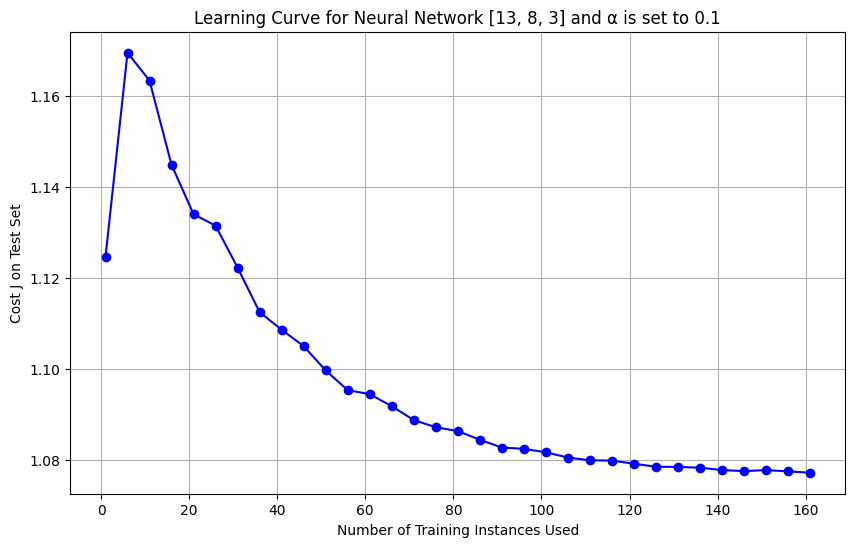

In [19]:
def learning_curve(X_train, y_train, X_test, y_test, nn, increments=5):
    costs = []
    for i in range(1, len(X_train), increments):
        nn.train(X_train[:i], y_train[:i], iterations=1)
        activations, _ = nn.forward(X_test)
        cost = nn.cost(y_test, activations[-1])
        costs.append(cost)
    return costs


np.random.seed(0)
nn = NN([13, 8, 3], eta=0.1, reg_lambda=0.05, use_softmax=True)
costs = learning_curve(X_train, y_train, X_test, y_test, nn)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X_train), 5), costs, marker='o', linestyle='-', color='b')
plt.title('Learning Curve for Neural Network [13, 8, 3] and α is set to 0.1')
plt.xlabel('Number of Training Instances Used')
plt.ylabel('Cost J on Test Set')
plt.grid(True)
plt.show()

α is set to 0.1